In [79]:
import numpy as np
from utils import *
from scipy.stats import binom
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.integrate import quad

## Utility Functions

In [80]:
def find_max(function, bound_low, bound_high, grid=100000,):
    """
    Return the maximum value of a function
    """
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    y = function(x)
    return y.max()

def find_significance(pdf, interval_limits):
    """
    Compute the p_value and significance value of a interval
    """

    # Compute integrals
    full_integral = pdf.integrate( (pdf.boundMin, pdf.boundMax) )
    interval_integral = pdf.integrate(interval_limits)

    # Compute p value of probability
    p_value = interval_integral/full_integral

    n_sigma = compute_z_score(p_value)

    return (p_value, n_sigma) 

def compute_z_score(p_value):
    """
    Compute significance value from p_value
    """

    # Compute Z score
    n_sigma = np.sqrt(2) * erfinv(1 - p_value)

    return n_sigma

def compute_time_of_flight(momentum, particle, length=20.0, light_speed=3e8,):
    match particle:
        case "pion": 
            mass = 139.6        # MeV/c
        case "kaon":
            mass = 493.7        # MeV/c
        case _:
            raise ValueError("String provided for particle invalid. Must be 'muon' of 'kaon'")
    return (length/light_speed) * np.sqrt(1+(mass*light_speed/momentum)**2)

## Classes

### Parent Classes

In [81]:
class ProbabilityDensityFunction(object):
    """
    Parent class containing common methods and members to be used by all pdf classes
    """

    def __init__(self, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")
        
        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        # Initialise list to hold randomly generated mass values
        self.mass = []

    def integrateBounded(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        lowerLimit, upperLimit = limits
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult

    def getMass(self,):
        """
        Return numpy array containing all generated values
        """

        return np.array(self.mass)
    

### Child Classes

In [82]:

class Gaussian(ProbabilityDensityFunction):
    """
    Class that will generate a random value according to a gaussian distribution using numpy.random.normal
    """

    def __init__(self, mean, sigma, bounds):

        # Initialise parent class
        super().__init__(bounds)
        
        # Initialise class variables
        self.mean = mean
        self.sigma = sigma
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the gaussian function of the distribution
        ##### NOTE: Returns un-normalised values between the bounds #####
        """

        return 1/(self.sigma * np.sqrt(2.0*np.pi)) * np.exp( -(x-self.mean)**2 / (2.0 * self.sigma**2) )

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using numpy.random.normal method
        Will return and append generated variable to mass list.
        """

        # Use .item() to append vsariable inside array and not array itself
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x


    def generateEvents(self, numberEvents):
        """
        Generate specified number of events and store them in self.mass
        """

        if isinstance(numberEvents, int):
            raise ValueError("Number of events must be type int")
        
        if (not numberEvents > 0):
            raise ValueError("Number of events must be a positive integer") 

        # Iterate over number of specidied events
        for _ in range(numberEvents):
            _ = self.next()

    def getObservedEvents(self,numberBins):
        """
        Compute and return the number of observed events and bins for a pdf using simulated 
        """

        nObservedEvents, bins , _ = plt.hist(self.mass, bins=numberBins)
        xBins = ( bins + (bins[1]-bins[0])/2 )[:-1]          # Center-point value of bins (Eliminate last element)

        return nObservedEvents, xBins

    def setParameters(self, mean=None, sigma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not mean == None:                self.mean = mean 
        if not sigma == None:               self.sigma = sigma

    
    def integrateAbove(self, lowerLimit,):
        """
        Evaluate the integral of the pdf between specified value and positive infinity.
        Here we define positive infinity to be 7 sigma above the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not lowerLimit >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not lowerLimit <= self.boundMax):
            raise ValueError("Lower integral limit must be smaller than upper bound of pdf")
        
        upperLimit = self.mean + 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, lowerLimit) 
        return integralResult

    def integrateBelow(self, upperLimit,):
        """
        Evaluate the integral of the pdf between specified value and negative infinity.
        Here we define positive infinity to be 7 sigma below the mean (to include ~100% of gaussian)
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not upperLimit >= self.boundMin):
            raise ValueError("Upper integral limit must be larger than lower bound of pdf")
        if (not upperLimit <= self.boundMax):
            raise ValueError("Upper integral limit must be smaller than upper bound of pdf")
        
        lowerLimit = self.mean - 10*self.sigma
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, lowerLimit) 
        return integralResult


class ROC(object):
    """
    Class which will compute the ROC parameters of two particle hypothesese given a measured particle momentum
    """

    def __init__(self, momentum, sigma, nStep=100):

        # Find mean time of flight for both particles
        mean_kaon = compute_time_of_flight(momentum, "kaon")
        mean_pion = compute_time_of_flight(momentum, "pion")
        print(f"Pion mean TOF: {mean_pion:.4f}\t\t Kaon mean TOF: {mean_kaon:.4f}")
        # Compute 10 sigma bounds
        bounds_kaon = (mean_kaon - 10*sigma, mean_kaon + 10*sigma)
        bounds_pion = (mean_pion - 10*sigma, mean_pion + 10*sigma)

        # Initialise pdf objects for both particles
        self.pdf_kaon = Gaussian(mean_kaon, sigma, bounds_kaon)
        self.pdf_pion = Gaussian(mean_pion, sigma, bounds_pion)

        # Define array containing tCut values at each performance point
        self.performancePoints = np.linspace(mean_pion, mean_kaon, nStep, endpoint=True)
        print(self.performancePoints)

        # Initialise empty lists to hold alpha and beta values
        self.alphaValues = []
        self.betaValues = []


    def _computeErrors(self, tCut):
        """
        Compute the alpha and beta values for both hypothese
        """

        # We choose that particle being a kaon is out null hypothesis. We also choose pion as our alternative
        # hypothesis. As such alpha is kaon area below tCut and beta is pion area above tCut

        alpha = self.pdf_kaon.integrateBelow(tCut,)
        beta = self.pdf_pion.integrateAbove(tCut,)
        print(alpha, beta)

        return (alpha, beta)
        
    def computeROC(self,):
        """
        Compute alpha and beta values for all performance points defined in class
        """

        for tCut in self.performancePoints:
            alpha, beta = self._computeErrors(tCut)
            self.alphaValues.append(alpha)
            self.betaValues.append(beta)

    def getAlphas(self,):
        """
        Return alpha values of ROC
        """      

        return self.alphaValues

    def getBetas(self,):
        """
        Return beta values of ROC
        """      

        return self.betaValues

## Excercises

Below are the 4 excersices for the checkpoint

### Excercise 1

In [83]:
CLAIMED_FAULTY_RATE = 0.05
ACTUAL_FAULTY_RATE = 0.15
# Pick a sufficiently large limit
SAMPLE_SIZE = 100
X_CUT = 9


x = np.arange(0, 100, 1,)
claimed_faulty_distribution = binom(SAMPLE_SIZE, CLAIMED_FAULTY_RATE)
actual_faulty_distribution = binom(SAMPLE_SIZE, ACTUAL_FAULTY_RATE)

# Compute Type-I error 
x_mask_type_1 = x > X_CUT
type_1_error = claimed_faulty_distribution.pmf(x)[x_mask_type_1].sum()

# Compute Type 2 mask
# Not that the mask used is the inverse of the mask calculated above
x_mask_type_2 = ~ x_mask_type_1
type_2_error = actual_faulty_distribution.pmf(x)[x_mask_type_2].sum()

print(f"The type I error is {type_1_error:.3f}")
print(f"The type II error is {type_2_error:.3f}")

The type I error is 0.028
The type II error is 0.055


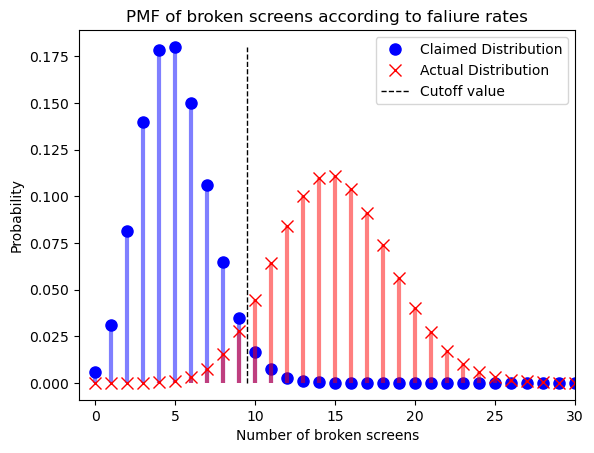

In [84]:
fig, ax = plt.subplots(1, 1)

# Plot claimed distribution
ax.plot(x, claimed_faulty_distribution.pmf(x), 'bo', ms=8, label='Claimed Distribution')
ax.vlines(x, 0, claimed_faulty_distribution.pmf(x,), colors='b', lw=3, alpha=0.5)

ax.plot(x, actual_faulty_distribution.pmf(x), 'rx', ms=8, label='Actual Distribution')
ax.vlines(x, 0, actual_faulty_distribution.pmf(x,), colors='r', lw=3, alpha=0.5)
ax.vlines(X_CUT+0.5, 0, claimed_faulty_distribution.pmf(x).max(), colors="black", linestyles="--", label="Cutoff value", lw=1)

plt.legend()
plt.xlabel("Number of broken screens")
plt.ylabel("Probability")
plt.title("PMF of broken screens according to faliure rates")
plt.xlim(-1, 30)
plt.show()

### Excercise 2

Pion mean TOF: 1.3960		 Kaon mean TOF: 4.9370
[1.396      1.43176768 1.46753535 1.50330303 1.53907071 1.57483838
 1.61060606 1.64637374 1.68214141 1.71790909 1.75367677 1.78944444
 1.82521212 1.8609798  1.89674747 1.93251515 1.96828283 2.00405051
 2.03981818 2.07558586 2.11135354 2.14712121 2.18288889 2.21865657
 2.25442424 2.29019192 2.3259596  2.36172727 2.39749495 2.43326263
 2.4690303  2.50479798 2.54056566 2.57633333 2.61210101 2.64786869
 2.68363636 2.71940404 2.75517172 2.79093939 2.82670707 2.86247475
 2.89824242 2.9340101  2.96977778 3.00554545 3.04131313 3.07708081
 3.11284848 3.14861616 3.18438384 3.22015152 3.25591919 3.29168687
 3.32745455 3.36322222 3.3989899  3.43475758 3.47052525 3.50629293
 3.54206061 3.57782828 3.61359596 3.64936364 3.68513131 3.72089899
 3.75666667 3.79243434 3.82820202 3.8639697  3.89973737 3.93550505
 3.97127273 4.0070404  4.04280808 4.07857576 4.11434343 4.15011111
 4.18587879 4.22164646 4.25741414 4.29318182 4.32894949 4.36471717
 4.40048485 4.43

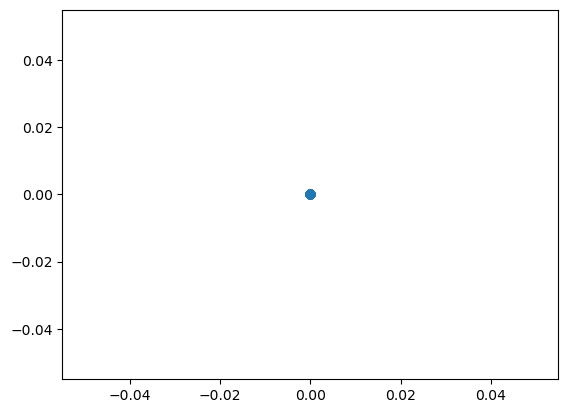

In [85]:
MASS_KAON = 493.7           # MeV/c**2
MASS_PION = 139.6
DISTANCE = 20.0             # m
SPEED_LIGHT = 1             # m/s
SIGMA = 400                 # ps

# Compute average time for particles

low_momentum_roc = ROC(2e3, SIGMA, 100)
medium_momentum_roc = ROC(3e3, SIGMA, 100)
high_momentum_roc = ROC(6e3, SIGMA, 100)

low_momentum_roc.computeROC()
alphas = low_momentum_roc.getAlphas()
betas = low_momentum_roc.getBetas()
print(alphas)
plt.scatter(alphas, betas)